In [21]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
np.random.seed(0)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-01,320.434998,320.434998,314.002991,314.248993,314.248993,8036550
2015-01-02,314.079010,315.838989,313.565002,315.032013,315.032013,7860650
2015-01-03,314.846008,315.149994,281.082001,281.082001,281.082001,33054400
2015-01-04,281.145996,287.230011,257.612000,264.195007,264.195007,55629100
2015-01-05,265.084015,278.341003,265.084015,274.473999,274.473999,43962800


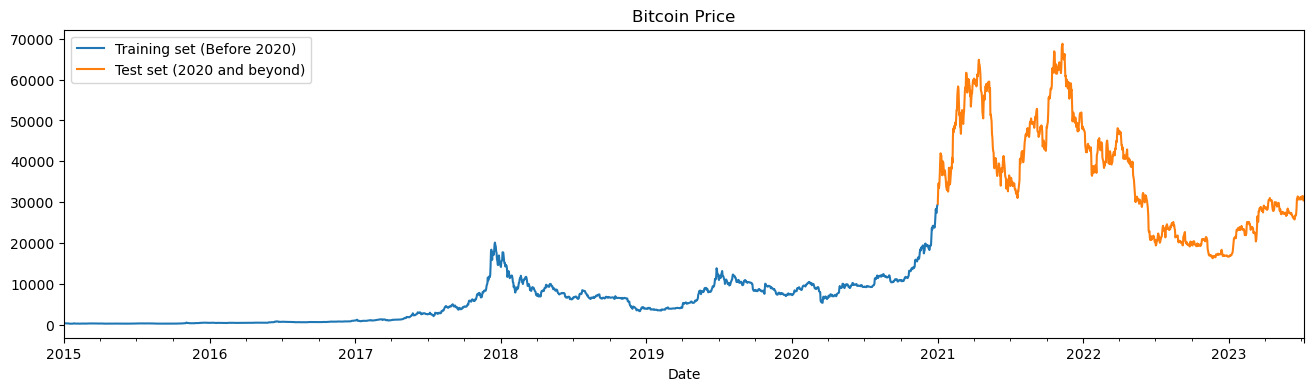

In [41]:
dataset = pd.read_csv('BTC-USD.csv', index_col='Date', parse_dates=['Date'])
display(dataset.head())

# We are going to predict the high attribute of stocks. Let's visualize it
dataset["High"][:'2020'].plot(figsize=(16,4),legend=True)
dataset["High"]['2021':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2020)','Test set (2020 and beyond)'])
plt.title('Bitcoin Price')
plt.show()

In [42]:
dataset.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [43]:
rowswithnull =dataset[dataset.isnull().any(axis=1)]
rowswithnull.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,


In [44]:
rowswithoutnulls = dataset[dataset.notnull().all(axis=1)]
rowswithoutnulls.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-01,320.434998,320.434998,314.002991,314.248993,314.248993,8036550
2015-01-02,314.079010,315.838989,313.565002,315.032013,315.032013,7860650
2015-01-03,314.846008,315.149994,281.082001,281.082001,281.082001,33054400
2015-01-04,281.145996,287.230011,257.612000,264.195007,264.195007,55629100
2015-01-05,265.084015,278.341003,265.084015,274.473999,274.473999,43962800


In [45]:
dataset = rowswithoutnulls
rowswithoutnulls.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [47]:
train_set = dataset[:'2020']["High"].values
test_set = dataset['2021':]["High"].values
print(train_set.shape, test_set.shape)

(2192,) (920,)


In [48]:
# Scaling the train and test sets
scaler = MinMaxScaler(feature_range=(0, 1))
train_set = scaler.fit_transform(np.reshape(train_set, (-1, 1)))
test_set = scaler.fit_transform(np.reshape(test_set, (-1, 1)))

sequence_length = 30
# Since RNNs work across time, we create a data structure with 'sequence_length' timesteps and 1 output
# So for each element of train set, we have 'sequence_length' previous training set elements 
X_train, Y_train = list(), list()
for i in range(train_set.shape[0] - sequence_length):
    X_train.append(train_set[i:i + sequence_length, 0])
    Y_train.append(train_set[i + sequence_length, 0])
X_train, Y_train = np.asarray(X_train), np.asarray(Y_train)

# Preparing the test set as well
X_test, Y_test = list(), list()
for i in range(test_set.shape[0] - sequence_length):
    X_test.append(test_set[i:i + sequence_length, 0])
    Y_test.append(test_set[i + sequence_length, 0])
X_test, Y_test = np.asarray(X_test), np.asarray(Y_test)
print(X_train.shape, X_test.shape)
print(Y_train.shape, Y_test.shape)

(2162, 30) (890, 30)
(2162,) (890,)


In [49]:
model = Sequential([
        LSTM(30, input_shape = (sequence_length,1), activation = 'tanh'),
        Dense(units = 64, activation="relu"),
        Dropout(0.1),
        Dense(units = 1, activation = 'relu'),
    ]) 

model.compile(loss = 'mean_squared_error', optimizer = 'adam')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 30)                3840      
                                                                 
 dense_4 (Dense)             (None, 64)                1984      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5889 (23.00 KB)
Trainable params: 5889 (23.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [50]:
history = model.fit(X_train, Y_train,validation_data=(X_test,Y_test), epochs= 20, batch_size = 4)
loss_history = history.history['loss']

Epoch 1/20
541/541 [==============================] - 6s 8ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 2/20
541/541 [==============================] - 4s 8ms/step - loss: 9.0118e-04 - val_loss: 0.0015
Epoch 3/20
541/541 [==============================] - 4s 8ms/step - loss: 6.7570e-04 - val_loss: 0.0011
Epoch 4/20
541/541 [==============================] - 4s 8ms/step - loss: 5.3718e-04 - val_loss: 0.0014
Epoch 5/20
541/541 [==============================] - 4s 8ms/step - loss: 5.3003e-04 - val_loss: 0.0016
Epoch 6/20
541/541 [==============================] - 4s 8ms/step - loss: 5.1743e-04 - val_loss: 0.0022
Epoch 7/20
541/541 [==============================] - 4s 7ms/step - loss: 4.3690e-04 - val_loss: 7.9085e-04
Epoch 8/20
541/541 [==============================] - 4s 7ms/step - loss: 4.4895e-04 - val_loss: 0.0011
Epoch 9/20
541/541 [==============================] - 4s 7ms/step - loss: 3.9395e-04 - val_loss: 7.5951e-04
Epoch 10/20
541/541 [==============================] - 4s 7m

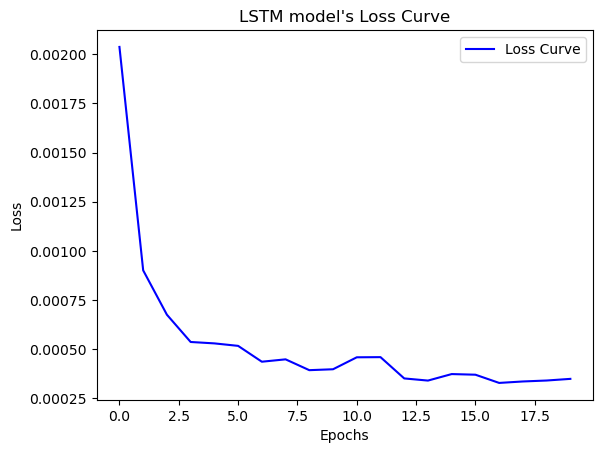

In [51]:
plt.plot(loss_history, color = 'blue', label = 'Loss Curve')
plt.title('LSTM model\'s Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

28/28 [==============================] - 0s 3ms/step


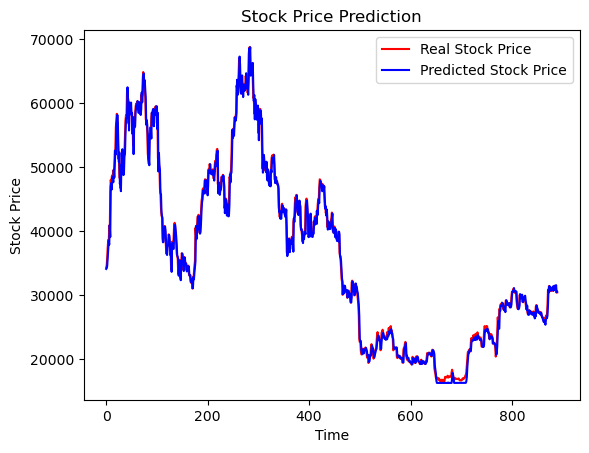

In [52]:
test_predict = model.predict(X_test)
orgpredict = scaler.inverse_transform(test_predict)
y_test_org =scaler.inverse_transform(Y_test.reshape(-1, 1))
plt.plot(y_test_org, color='red',label='Real Stock Price')
plt.plot(orgpredict, color='blue',label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

28/28 [==============================] - 0s 3ms/step


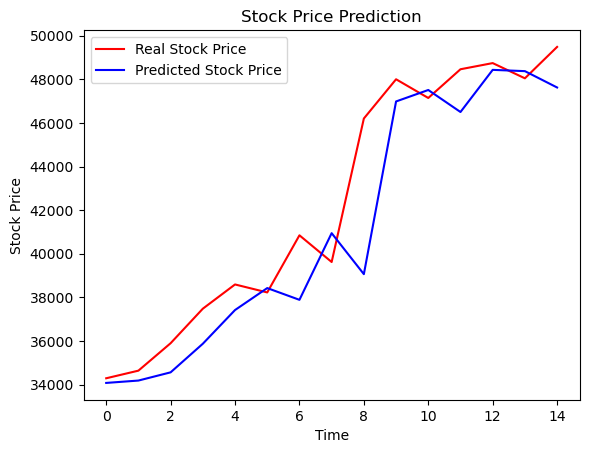

In [58]:
test_predict = model.predict(X_test)
orgpredict = scaler.inverse_transform(test_predict)
y_test_org =scaler.inverse_transform(Y_test.reshape(-1, 1))
plt.plot(y_test_org[:15], color='red',label='Real Stock Price')
plt.plot(orgpredict[:15], color='blue',label='Predicted Stock Price')
plt.title('Bitcoin Price Prediction')
plt.xlabel('Time')
plt.ylabel('Bitcoin Price')
plt.legend()
plt.show()

In [59]:
loss = (np.sum(np.square(Y_test - np.squeeze(test_predict)))/len(test_predict))
print("Loss: ",loss)

Loss:  0.0005381948134342567


In [60]:
r_squared = r2_score(Y_test[:15], np.squeeze(test_predict[:15]))
print("R-squared:", r_squared)

R-squared: 0.8351114626111192


In [61]:
y_pred = orgpredict[:15]
y_true = y_test_org[:15]
def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def median_absolute_percentage_error(y_true, y_pred):
    return np.median(np.abs((y_true - y_pred) / y_true)) * 100

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

mae = mean_absolute_error(y_true, y_pred)
mdape = median_absolute_percentage_error(y_true, y_pred)
rmse = root_mean_squared_error(y_true, y_pred)

print("Mean Absolute Error (MAE):", mae)
print("Median Absolute Percentage Error (MdAPE):", mdape)
print("Root mean square error (RMSE):", rmse)

Mean Absolute Error (MAE): 1483.474479166665
Median Absolute Percentage Error (MdAPE): 3.040802169743823
Root mean square error (RMSE): 2253.919685219584


In [37]:
# test_predict = []
# test = X_test[len(X_test) - 1:]
# for i in range(100):
#     prediction = model.predict(test, verbose = 2)
#     print(len(Y_test) - i)
#     print(test)
#     test_predict.append(prediction[0][0])
#     for j in range(1, sequence_length):
#         test[0][j - 1] = test[0][j]
#     test[0][sequence_length - 1] = prediction[0][0]
# # orgpredict = scaler.inverse_transform(test_predict)
# # y_test_org =scaler.inverse_transform(Y_test.reshape(-1, 1))
# plt.plot(Y_test[:20], color='red',label='Real Stock Price')
# plt.plot(test_predict[:20], color='blue',label='Predicted Stock Price')
# plt.title('Stock Price Prediction')
# plt.xlabel('Time')
# plt.ylabel('Stock Price')
# plt.legend()
# plt.show()

In [38]:
# r_squared = r2_score(Y_test[:20], np.squeeze(test_predict[:20]))
# print("R-squared:", r_squared)